# HyperCubes

I needed to make a definition of a cube that I could extend consistently to more dimensions.

I started by thinking about the vertices of a unit cube in $d$ dimensions (which I will call a "$d$-cube"), where each vertex is defined by a rank-$d$ vector, which can be represented as a tuple of $d$ numbers. The value of each of those $d$ coordinates can be either $0$ or $1$, and I think we need to enumerate all combinations to get the full set of vertices. I realized that I can generate (or count) those combinations by counting in binary with $d$ bits. This implied to me that there are $2^d$ vertices for a $d$-cube, and this agrees with 4 vertices for a 2D square ("2-cube") and 8 vertices for a 3D cube ("3-cube"). So I decided to generate the $2^d$ vertices of a $d$-cube by counting up in binary for $d$ bits and then setting the value of each member of rank-$d$ tuple for the vector to that vertex to the value of the corresponding bit. After generating all of the vertices of the $d$-dimensional unit cube, I can then subtract $\frac{1}{2}$ from each coordinate of every vector to center the $d$-cube around the origin of the coordinate system.

For images of $4$-cubes (hypercubes or tesseracts), I realized that it looks like they are drawing the edges of the cube rather than the faces, so I thought about how to generate a complete list of unique edges to draw. I think each vertex of a $d$-cube is connected to $d$ edges, where each of the edges is parallel to one of the coordinate vectors. So, if there are $2^d$ vertices, and each vertex is connected to $d$ edges, but each edge is connected to 2 vertices and I do not want to double-count, then there are $d*2^d/2 = d*2^{(d-1)}$ total unique edges.

For a unit cube, I know each edge should have a length of $1$. I think this implies that for 2 vertices to be connected by an edge, then they must differ in one and only one coordinate. If all of the coodinates of each vector are the same, then it is the same vertex, and we do not connect it to itself. If more than one coordinate differs, then I think the length of the connecting edge will be greater than $1$, so it would be some sort of internal diagonal connection, rather than an outer edge. To determine which vertices to connect, one could use direct comparison of number of differing coordinates, or alternatively one could measure the distances between pairs of vertices. I chose the latter method.

In [ ]:
# evaluate first on google colab, otherwise skip
!pip install -q ipympl
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
#%matplotlib widget
%matplotlib ipympl

In [1]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import numpy.random as nr

Define functions to generate the vertices and edges for $d$-cubes

In [4]:
# generate vertices of a cube in d dimensions
# enumerate all combinations of {0,1} in each of d dimensions
# this is like counting in binary with d bits
# so there are 2^d vertices
# subtract 0.5 from each dimension of each vertex to center the cube
# input: number of dimensions (scalar)
# output: 2D array of size 2^d x d
# first dimension indexes over vertices
# second dimension indexes the coordinates of the vector to a vertex
def vertices(d):
    nv = 2**d
    va = np.zeros([nv,d])
    for i in range(nv):
        for j in range(d):
            b = 2**j
            va[i][j] = (i & b)/b
    return va - 0.5

# squared distance between 2 points in d-dimensional space
# input: p1 and p2 are 1D arrays, each of length d
# output: squared distance between p1 and p2 (a scalar value)
def distsq(p1,p2):
    return ((p1-p2)**2).sum()

# each vertex has d edges
# for number of unique edges, divide by 2 since an edge connects 2 vertices
# so there are d*2^(d-1) unique edges in d dimensions
# compare each vertex to all other vertices (no self-comparison)
# only define edges to draw where distance between vertices is one
# define each edge by its 2 endpoints
# no particular order of vertices in edge definition
# no particular order of edges in d-cube definition
# input: number of dimensions (scalar)
# output: 3D array of size d*2^(d-1) x 2 x d
# first dimension indexes over edges
# second dimension indexes over the 2 endpoint vertices of the edge
# third dimension indexes the coordinates of the vector to a vertex
def edges(d):
    va = vertices(d)
    nv = len(va)
    ne = d*2**(d-1)
    ea = np.zeros([ne,2,d])
    indx = 0
    for i in range(nv):
        vi = va[i]
        for j in range(i+1,nv):
            vj = va[j]
            if distsq(vi,vj) <= 1.0:
                ea[indx][0] = vi
                ea[indx][1] = vj
                indx += 1
    return ea

Define functions to plot in 2D and 3D

In [10]:
# given array of edges
# each edge defined by a pair of 2D points
# draw a line to represent each edge
def draw2d(ea):
    ne = len(ea)
    plt.figure().clf()
    for i in range(ne):
        x = [ea[i][0][0], ea[i][1][0]]
        y = [ea[i][0][1], ea[i][1][1]]
        plt.plot(x,y)
    plt.gca().set_aspect('equal')
    return

# given list of edges
# each edge defined by a pair of 3D points
# draw a line to represent each edge
def draw3d(ea):
    ne = len(ea)
    ax = plt.figure().add_subplot(projection='3d')
    ax.cla()
    for i in range(ne):
        x = [ea[i][0][0], ea[i][1][0]]
        y = [ea[i][0][1], ea[i][1][1]]
        z = [ea[i][0][2], ea[i][1][2]]
        ax.plot(x,y,z)
    ax.set_aspect('equal')
    #ax.legend()
    return

Generate edges for unit $d$-cubes in some interesting dimensions

In [29]:
# instantiate arrays of edges for d-cubes in 2, 3, 4, and 5 dimensions
edges2d = edges(2) # square
edges3d = edges(3) # cube
edges4d = edges(4) # hypercube
edges5d = edges(5) # 5-cube

Draw a familiar 2D square in 2D

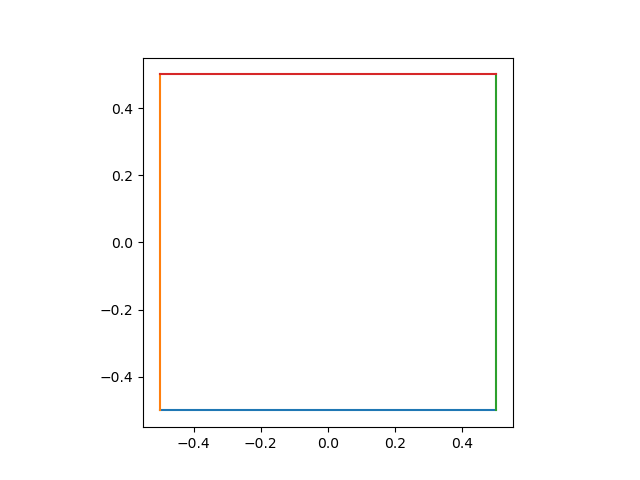

In [15]:
# draw 2-cube in 2 dimensions
draw2d(edges2d);plt.show()

Draw a familiar 3D cube in "3D", but since the computer screen is flat, what we are actually doing is projecting the edges of the 3D cube onto a 2D plane. Hopefully this plot is interactive so the user can use the mouse to drag the 3D cube around and see if from different angles. I think this gives the sense of 3D because our brains already have experience with seeing 3D objects from different angles, so our brains put it together for us.

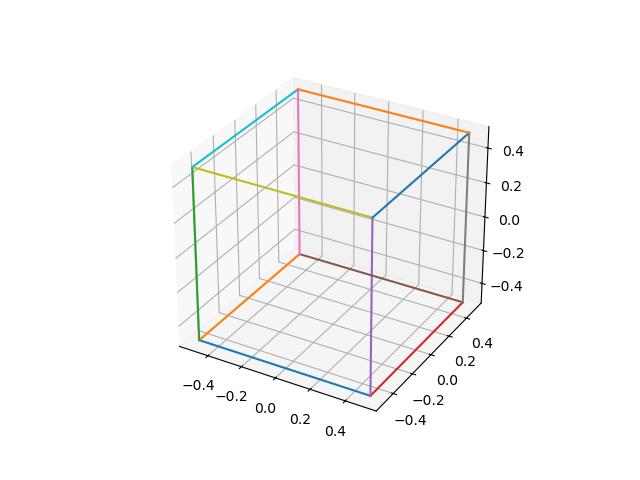

In [13]:
# draw 3-cube in 3 dimensions
# hopefully 3D plot is interactive
draw3d(edges3d);plt.show()

Each frame of "rendering" the 3D cube involves projecting the vectors representing the vertices into a 2D subspace where the orientation is determined by how we have dragged the view around, and then drawing the edges that connect the correct pairs of vertices. Now I want to write code that can render a single frame "by hand", but which will allow me to do projections other than just 3D to 2D.

In [30]:
# return unit vector in direction of input vector
# input: 1D array of length d
# output: 1D array of length d
def unitv(v):
    r = ((v**2).sum())**0.5
    return v/r

# generate random unit vector in d dimensions
# input: number of dimensions (scalar)
# output: 1D array of length d
def randuv(d):
    return unitv(nr.randn(d))

# dot product of 2 vectors in d dimensions
# input: v1 and v2 are 1D arrays, each of length d
# output: scalar
def dot(v1,v2):
    return (v1*v2).sum()

# generate a randomly oriented subspace of dimension d_out starting from dimension d_in, where d_out < d_in
# in practice this looks like generating a set of d_out orthonormal vectors, each of rank d_in
# I think I am essentially using Gram-Schmidt process
# input: d_in and d_out are scalars
# output: 2D array of size d_out x d_in
# first dimension indexes over the set of orthonormal vectors
# second dimension indexes the coordinates of each orthonormal vector
def rand_subspace(d_in, d_out):
    v = np.zeros([d_out, d_in])
    for i in range(d_out):
        tmp = randuv(d_in)
        for j in range(i):
            tmp = unitv(tmp - dot(tmp,v[j])*v[j])
        v[i] = tmp
    return v

# project edges that define a d-cube into a randomly oriented subspace
# this is probably some simple matrix multiplication
# but I tend to mix up row and column vectors in python
# so I just wrote loops that do the correct math
# input: an output from the "edges" function
# output: an output form the "rand_subscape" function
def project_subspace(edges_in, v):
    shape_in = edges_in.shape
    shape_out = (shape_in[0], shape_in[1], v.shape[0])
    edges_out = np.zeros(shape_out)
    for i in range(shape_out[0]):
        for j in range(shape_out[1]):
            for k in range(shape_out[2]):
                edges_out[i][j][k] = dot(edges_in[i][j],v[k])
    return edges_out

First we will project a 3D cube into a randomly oriented 2D plane and check that it looks like a still frame from the interactive "3D" drawing of the cube above. The next notebook cell will generate a new randomly oriented 2D plane each time it is evaluated, so go ahead and evaluate it a few times to get used to how it is showing us different "shadows" of a 3D cube in 2D.

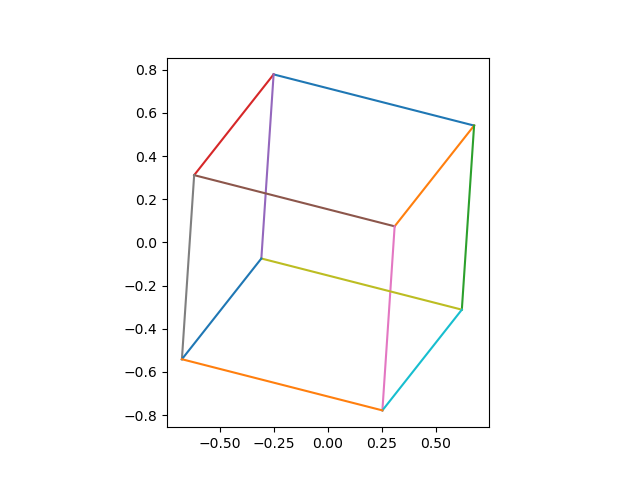

In [26]:
# project 3-cube into randomly oriented 2-space and draw in 2D
draw2d(project_subspace(edges3d,rand_subspace(3,2)));plt.show()

Now for the moment we have been waiting for - we will project a 4-cube ("hypercube") into a randomly oriented 3D space. And then we will use the "3D" rendering to allow us to view that projection from a variety of angles, so we can get a sense of what this "shadow" of a 4D cube would actually look like in 3D. As with the notebook cell above, re-evaluating it will generate a different orientation of the projection from 4D down to 3D, so running it a few times can give us a sense of what can change.

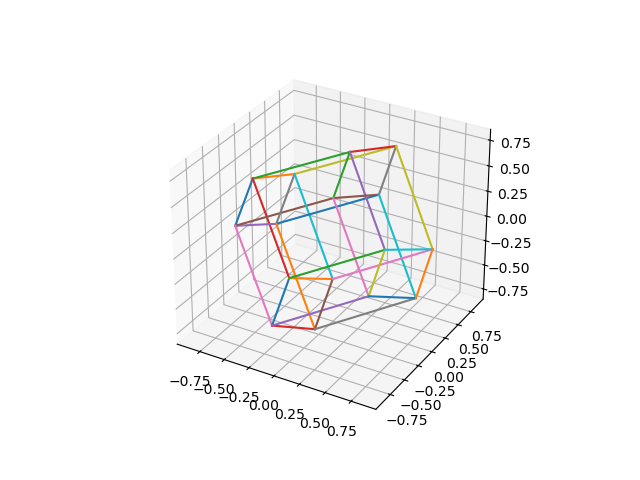

In [32]:
# project 4-cube into randomly oriented 3-space and draw in 3D
draw3d(project_subspace(edges4d,rand_subspace(4,3)));plt.show()

So what just happened? That did not look exactly like the tesseract we are used to seeing. Before I wrote this code, I figured that the tesseract represented a particular orientation of the shadow of a hypercube, probably involving some vectors parallel to the edges of the hypercube. So I did not expect edges to line up as neatly with a randomly oriented 3D space.

But what I realized in retrospect is that I never understood why the tesseract looks like a small cube inside a bigger cube when I know that all the edges of a cube are the same length. And, indeed, in my simple projections I feel like I'm seeing multiple warped cubes, but they are all the same size. So I do not think this kind of projection will ever produce the classic looking tesseract.

I did some reading, and I think the classic looking tesseract is generated using a "perspective" projection, where parts of the object that are "farther away" from the viewer will be drawn smaller compared to parts of the object that are "closer" to the viewer. My simple projection does not have anything like this, eg. parallel lines will stay parallel and they won't appear to converge to a point in the background.

At this point I am fairly happy with my code. I feel like I understand more about how to define, generate, and project $d$-cubes. I think that extending concepts like "perspective" and "rotations" from 3D to higher dimensions would be significantly more complicated, and I'm not sure whether those extensions are uniquely defined, or if one would have to make more decisions about what a higher dimensional equivalents are to concepts that we have an intuitive feel for in 3D.

What else can I do with this code? I guess I could skip the middle-man of the "3D" rendering and just project a 4-cube into a randomly oriented 2D space:

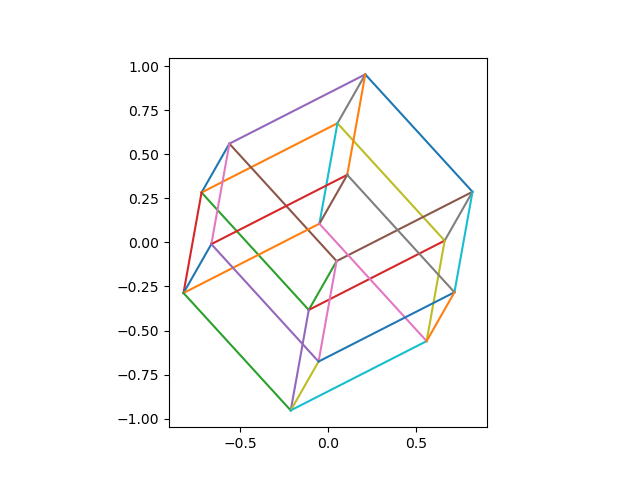

In [34]:
# project 4-cube into randomly oriented 2-space and draw in 2D
draw2d(project_subspace(edges4d,rand_subspace(4,2)));plt.show()

And I guess that means I could project a 5-cube into a randomly oriented 3D space:

/var/folders/vn/98976t1d7151sxx1qf94f5f80000gp/T/ipykernel_43133/3007673529.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  ax = plt.figure().add_subplot(projection='3d')


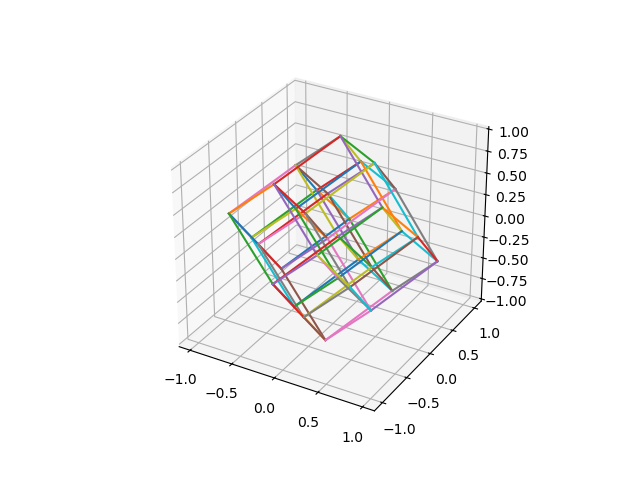

In [35]:
# project 5-cube into randomly oriented 3-space and draw in 3D
draw3d(project_subspace(edges5d,rand_subspace(5,3)));plt.show()

Ok, fine, maybe it would be fun to learn how perspective projections work so I could see what the equivalent of the tesseract looks like for a 5-cube. I'll think about it.